<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bambi-notebook)=
# Zucchero sintattico

I modelli lineari sono utilizzati così ampiamente che sono stati sviluppati appositamente una sintassi, dei metodi e delle librerie per la regressione. Una di queste librerie è `bambi` (BAyesian Model-Building Interface). `bambi` è un pacchetto Python per adattare modelli gerarchici generalizzati lineari (di cui il modello lineaere bivariato è un caso particolare), utilizzando una sintassi simile a quella che si trova nei pacchetti R, come `lme4`, `nlme`, `rstanarm` o `brms`. `bambi` è basato su PyMC ma fornisce un'API di più alto livello. 

In questo capitolo vedremo come svolgere l'analisi di regressione usando `bambi` anziché PyMC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
import xarray as xr
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Simuliamo i dati esattamente come abbiamo fatto nel capitolo precedente.

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

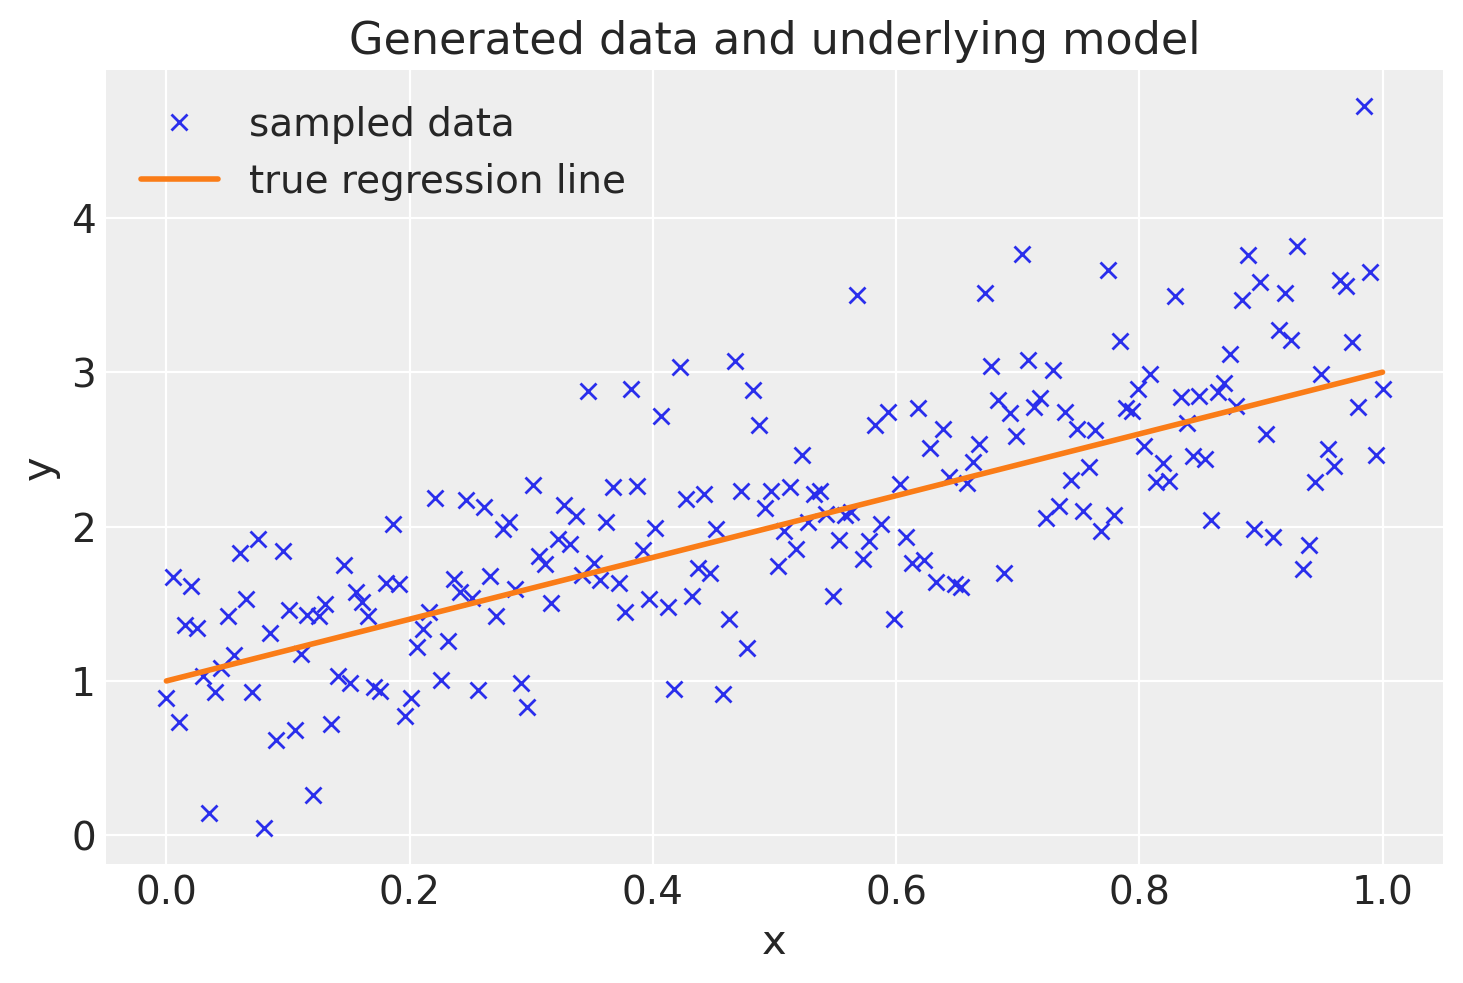

In [4]:
plt.plot(x, y, "x", label="sampled data")
plt.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated data and underlying model")
plt.legend(loc=0);

Per replicare il modello descritto nel capitolo {ref}`reglin-pymc-notebook`, possiamo utilizzare la seguente istruzione. La specificazione del modello è facilitata dall'adozione della notazione di Wilkinson {cite:p}`wilkinson1973symbolic`. Inoltre, `bambi` implementa delle distribuzioni a priori ottimizzate, eliminando così la necessità di definirle esplicitamente. Tuttavia, se si preferisce un maggiore controllo sulle distribuzioni a priori, è possibile specificarle manualmente.

In [5]:
model = bmb.Model("y ~ x", data)

Eseguiamo il campionamento MCMC.

In [6]:
idata = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:16.714043


Sampling...


  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                            | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                         | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1334.62it/s]


Running chain 1: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1336.56it/s]


Running chain 2: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1338.57it/s]


Running chain 3: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1340.11it/s]


Sampling time = 0:00:02.142154


Transforming variables...


Transformation time = 0:00:00.069204


Computing Log Likelihood...


Log Likelihood time = 0:00:01.275833


Le distribuzioni a posteriori dei parametri e i trace plot si ottengono con la seguente istruzione.

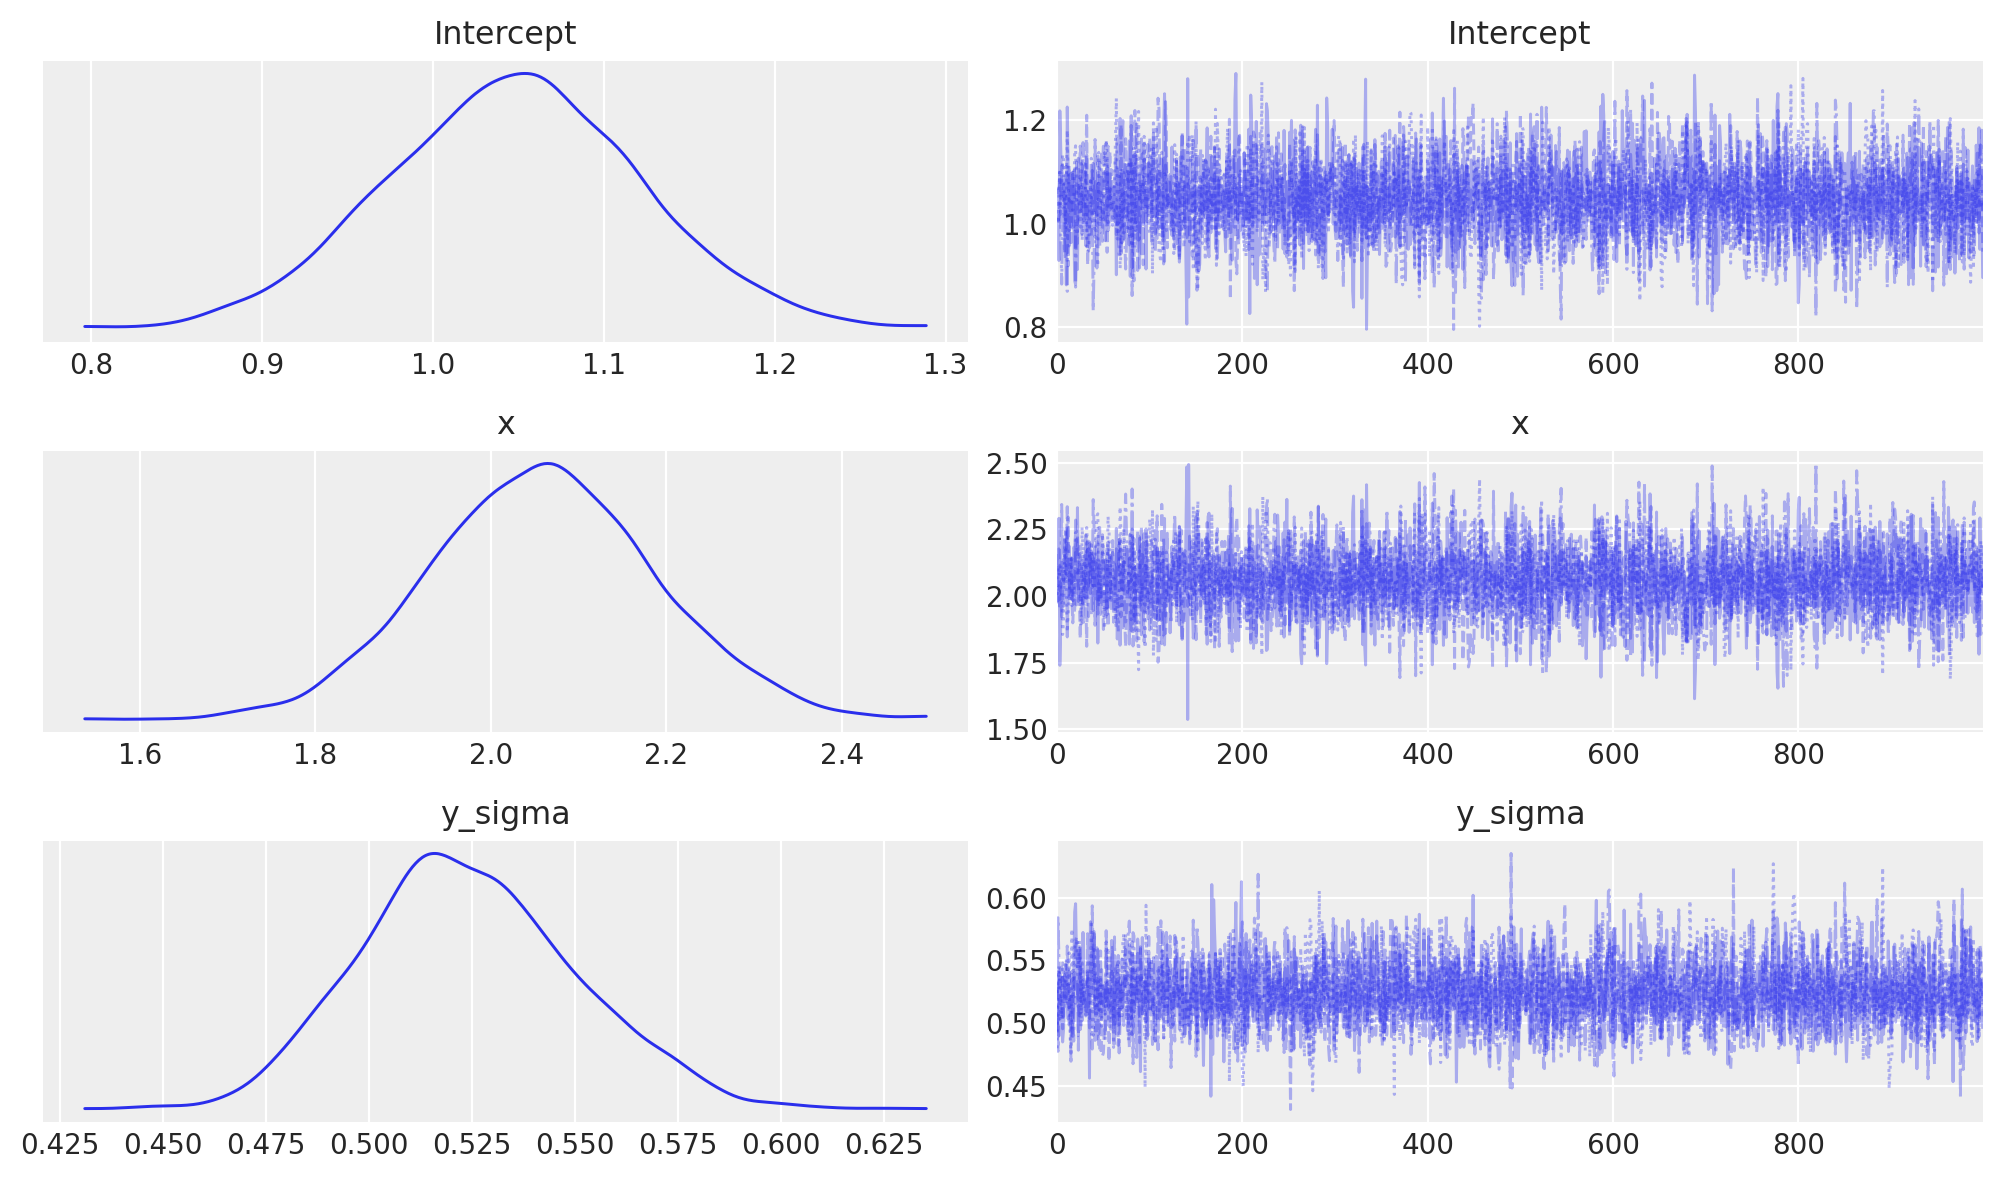

In [7]:
az.plot_trace(idata, combined=True, figsize=(10, 6))
plt.tight_layout();

Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [8]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.05,0.07,0.91,1.19,0.0,0.0,4225.53,3095.41,1.0
x,2.06,0.13,1.82,2.30,0.0,0.0,4086.49,2871.04,1.0
y_sigma,0.52,0.03,0.48,0.57,0.0,0.0,3674.48,2861.20,1.0


Si noti che i risultati replicano quelli ottenuti con PyMC.

Anche in questo caso è posibile generare un grafico che descrive l'incertezza a posteriori delle predizioni del modello. Un grafico predittivo a posteriori estrae più campioni dalla distribuzione a posteriori (intercette e pendenze) e traccia una retta di regressione per ciascuno di essi. Possiamo generare manualmente queste rette di regressione utilizzando direttamente i campioni a posteriori con l'istruzione seguente. Si noti che, usando `bambi`, il parametro $\alpha$ è denominato `Intercept`.

In [9]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

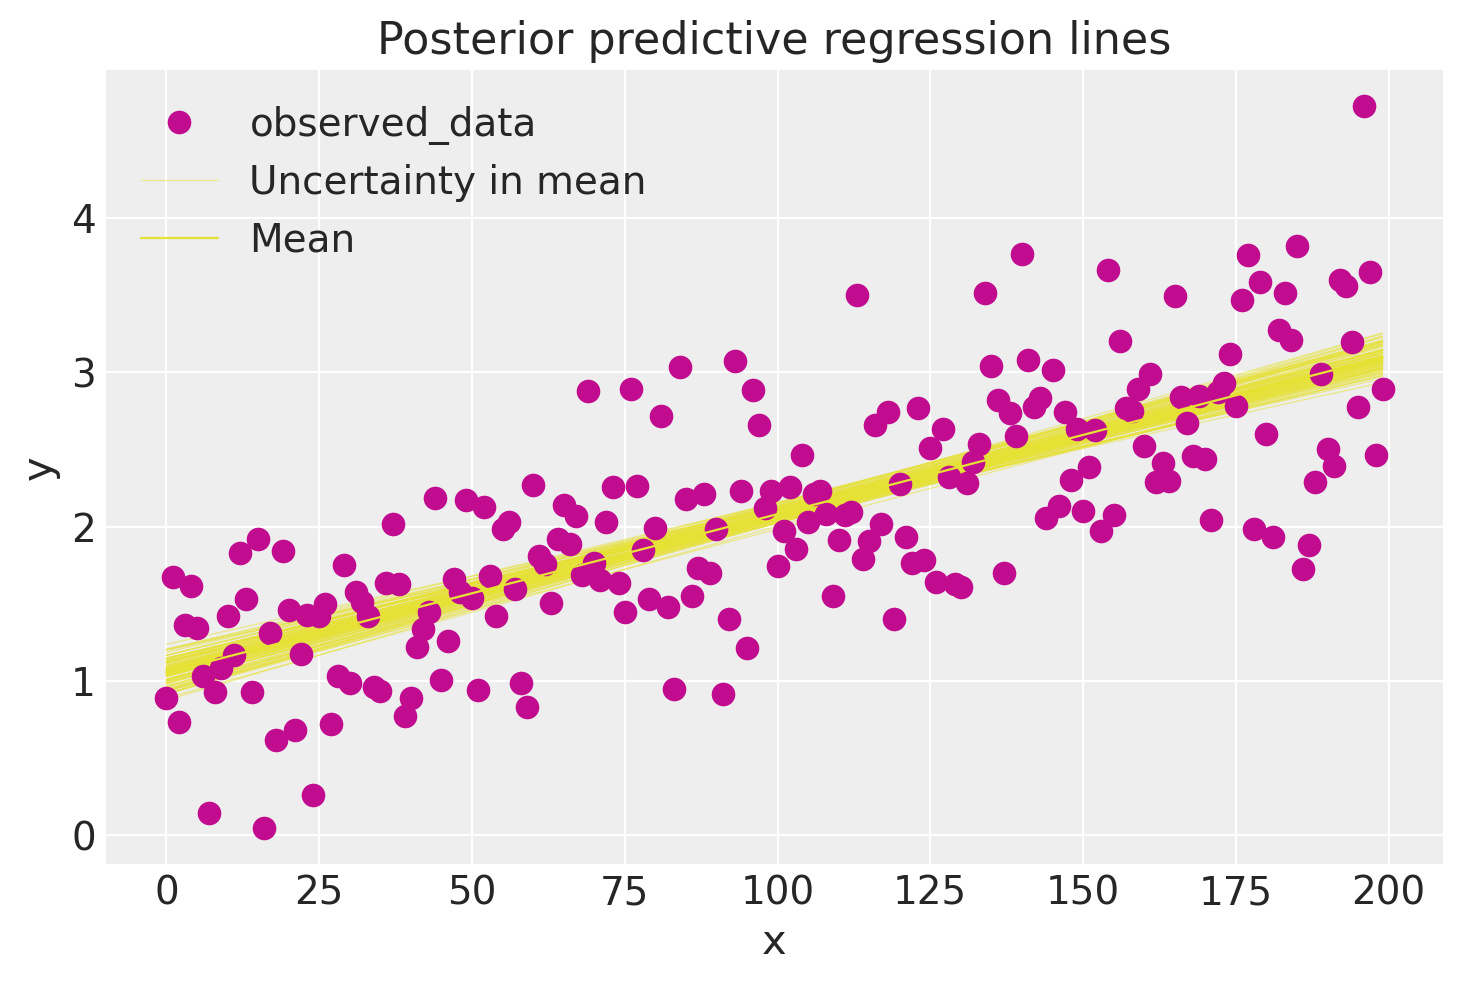

In [10]:
az.plot_lm(idata=idata, y="y", num_samples=100, y_model="y_model")
plt.title("Posterior predictive regression lines")
plt.xlabel("x");

Come abbiamo già osservato in precedenza, le rette di regressione stimate si avvicinano notevolmente alla vera retta di regressione. Tuttavia, dato che stiamo lavorando con un campione di dati e non con l'intera popolazione, le stime dei parametri della retta di regressione, quali intercetta e pendenza, sono soggette a un certo grado di incertezza. Questa incertezza non è un difetto, ma una rappresentazione naturale dell'informazione limitata che abbiamo a disposizione, e nel grafico è visualizzata attraverso la variabilità delle rette di regressione.

## Watermark

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Jan 05 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

pytensor: 2.18.4

bambi     : 0.13.0
seaborn   : 0.13.0
xarray    : 2023.12.0
numpy     : 1.26.2
arviz     : 0.17.0
matplotlib: 3.8.2
pandas    : 2.1.4

Watermark: 2.4.3

